In [183]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import torch

from idbd import IDBD

In [205]:
torch.manual_seed(42)

n_inputs = 100
noise_strength = 0.1

true_weights = torch.randn(1, n_inputs)
model = torch.nn.Linear(n_inputs, 1, bias=False)
torch.nn.init.zeros_(model.weight)

optimizer = IDBD(model.parameters(), meta_lr=0.01, init_lr=0.01, autostep=True)

In [206]:
# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs,), dtype=torch.float)
    noisy_X = true_X + torch.randn(n_inputs) * noise_strength
    y_pred = model(noisy_X)
    target = true_weights @ true_X
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses.append(loss.item())

    param_inputs = {model.weight: noisy_X}
    optimizer.zero_grad()
    optimizer.step(loss, y_pred, param_inputs)
    
    if i > 2000 and i % 200 == 0 and np.mean(losses[-400:-200]) - np.mean(losses[-200:]) <= 0:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))

Number of steps: 2401
Loss: 0.6549166054640682


In [207]:
# Add new inputs
new_model = torch.nn.Linear(n_inputs * 2, 1, bias=False)
torch.nn.init.zeros_(new_model.weight)
new_model.weight.data[:, :n_inputs] = model.weight.data

new_optimizer = IDBD(new_model.parameters(), meta_lr=0.01, init_lr=0.01, autostep=True)

old_state = optimizer.state[model.weight]
new_state = new_optimizer.state[new_model.weight]
for key, value in old_state.items():
    new_state[key][:, :n_inputs] = value

model = new_model
optimizer = new_optimizer

In [208]:
# Train until convergence

losses_2 = []

initial_weight_magnitudes = torch.abs(model.weight.data[0, :n_inputs].clone())
time_to_pass = torch.inf * torch.ones_like(initial_weight_magnitudes)

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs,), dtype=torch.float)
    noisy_X = true_X + torch.randn(n_inputs) * noise_strength
    full_X = torch.cat([noisy_X, true_X], dim=0)
    y_pred = model(full_X)
    target = true_weights @ true_X
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses_2.append(loss.item())

    param_inputs = {model.weight: full_X}
    optimizer.zero_grad()
    optimizer.step(loss, y_pred, param_inputs)
    
    if i % 100 == 0:
        orig_weights = model.weight.data[0, :n_inputs]
        new_weights = model.weight.data[0, n_inputs:]
        
        weight_surpassed = torch.abs(new_weights) > torch.abs(orig_weights)
        new_time_to_pass = torch.minimum(torch.full_like(time_to_pass, i), time_to_pass)
        time_to_pass = torch.where(weight_surpassed, new_time_to_pass, time_to_pass)
    
    if i > 50000 and i % 1000 == 0 and np.mean(losses_2[-20000:-10000]) - np.mean(losses_2[-10000:]) <= 0:
        break

print('Number of steps:', len(losses_2))
print('Loss:', np.mean(losses_2[-1000:]))

Number of steps: 203001
Loss: 0.047250671127631


tensor([4.1200e+04, 5.6300e+04, 7.4300e+04, 3.6000e+04, 1.3500e+05, 6.2600e+04,
        1.1000e+03, 4.8300e+04,        inf, 4.9600e+04,        inf, 5.3100e+04,
               inf, 1.7860e+05,        inf,        inf, 3.9300e+04, 1.0000e+03,
               inf,        inf, 5.8300e+04, 8.2100e+04, 7.5100e+04, 3.9200e+04,
        8.4400e+04, 7.2800e+04,        inf, 4.7800e+04,        inf, 3.0000e+02,
               inf, 1.0100e+05, 7.9900e+04,        inf, 1.2000e+03, 5.5100e+04,
               inf,        inf,        inf,        inf, 7.1400e+04, 1.1120e+05,
        1.4580e+05,        inf, 5.8600e+04, 2.6500e+04, 7.1300e+04,        inf,
        1.1910e+05,        inf, 2.0000e+02,        inf,        inf, 7.9600e+04,
               inf,        inf,        inf, 2.0000e+02, 8.0000e+02, 1.4110e+05,
        4.5000e+03, 4.0200e+04, 7.1900e+04, 6.2900e+04, 5.2800e+04, 1.1890e+05,
        3.4600e+04,        inf,        inf, 5.0000e+02, 9.5600e+04,        inf,
               inf,        inf, 1.0000e+

In [ ]:
# print(model.weight.data[0, :n_inputs])
# print(model.weight.data[0, n_inputs:])
# initial_weight_magnitudes


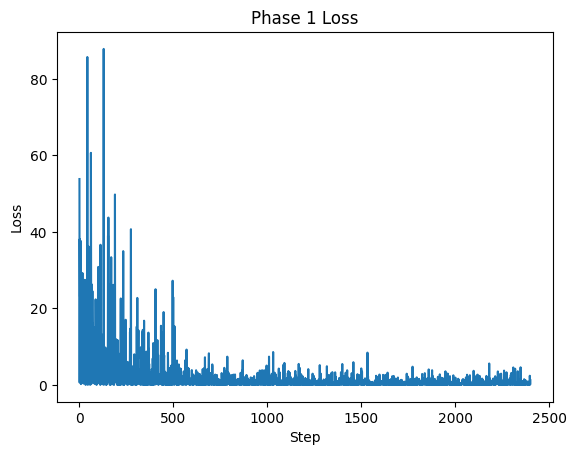

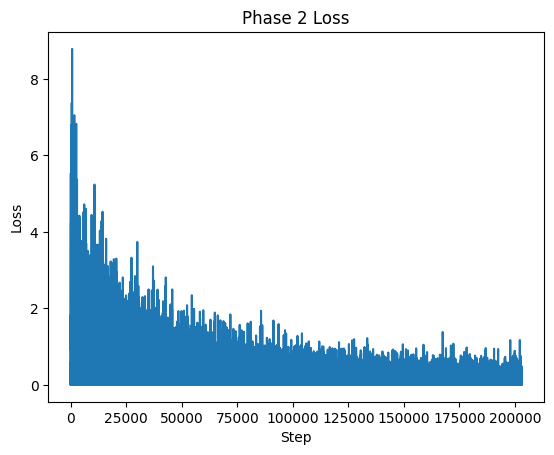

In [222]:
plt.plot(losses)
plt.title('Phase 1 Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

plt.plot(losses_2)
plt.title('Phase 2 Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()


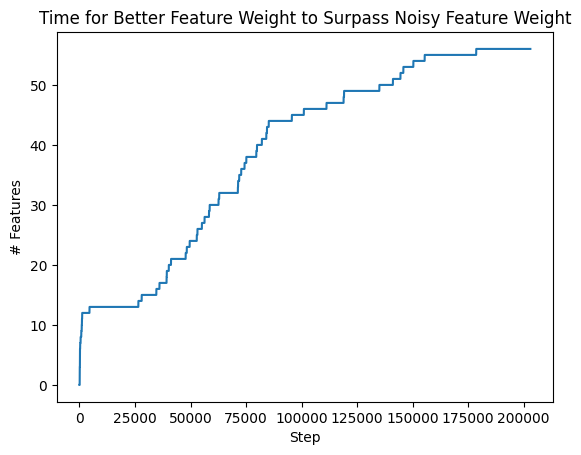

In [221]:
sorted_time_to_pass = sorted(time_to_pass.tolist())
pass_idx = 0
prev_pass_step = 0
plot_values = []
for pass_step in sorted_time_to_pass:
    if np.isinf(pass_step):
        plot_values.extend([pass_idx] * int(len(losses_2) - prev_pass_step))
        break
    plot_values.extend([pass_idx] * int(pass_step - prev_pass_step))
    prev_pass_step = pass_step
    pass_idx += 1

plt.plot(plot_values)
plt.title('Time for Better Feature Weight to Surpass Noisy Feature Weight')
plt.xlabel('Step')
plt.ylabel('# Features')
plt.show()

